# Introduction

Decision trees can learn rules to map features to both continous and discrete outputs. In this quiz, you will consider the continous case and implement a regression tree to predict house prices in Boston. You will also conduct small data analysis and evaluation procedures. This notebook will guide you through.

## (10 pts) Task 1: Dataset 

Run the cells below to load Boston house prices dataset using `scikit-learn`. You can find more detail on the dataset [here](https://scikit-learn.org/stable/datasets/index.html#boston-dataset).

When the dataset is loaded, construct train and test matrices, by allocating **first 400 samples** to train and the rest to test.

In [1]:
#Import necessary libraries

!pip install PTable
import numpy as np
from sklearn.datasets import load_boston
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.metrics import r2_score
import copy

In [2]:
#Read data, shuffle it and stay on the seed(2)

boston = load_boston()
X_y = np.column_stack([boston['data'], boston['target']])
np.random.seed(2)
np.random.shuffle(X_y)
X, y = X_y[:,:-1], X_y[:,-1]
train_data, train_label = X[:400], y[:400]
test_data, test_label = X[400:], y[400:]
del X, y, X_y

**(10 pts)** Unlike the dataset in Project 1, Boston dataset is high-dimensional and we cannot observe the relations between all features and the output with a single scatter plot. What we can do is to visualize the correlations between both features and house prices using a heatmap. So, stack the features and the outputs in a single matrix and compute correlation between all pairs of columns. Visualize the correlation coefficient matrix as a heatmap, which is $(N+1)x(N+1)$, where $N$ is the number of features in Boston dataset. You can check out `corrcoef` and `heatmap` functions from `numpy` and `seaborn` libraries, respectively. You can use diverging color palette to emphasize both positive and negative correlations.

Do you observe strong correlations between any pair of features or certain features and house price? 

In [3]:
#To show on the heatmap, add response variable name to the explanatory variable names

columns = np.append(boston.feature_names,'PRICE')

In [4]:
#Concatenate the train data and train label

all_data = np.concatenate((train_data, train_label[:,None]), axis=1)

In [5]:
#Calculate correlation between all features

correlation_matrix=np.corrcoef(all_data.transpose())

(14.0, 0.0)

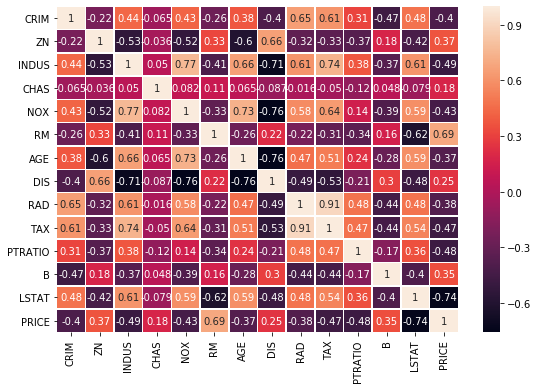

In [6]:
#Plot the heatmap 

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(correlation_matrix, xticklabels=columns, yticklabels=columns,annot=True, linewidths=.5, ax=ax)
ax.set_ylim(sorted(ax.get_xlim(), reverse=True))

## (80 pts) Task 2: Regression Tree


**(15 pts)** Let us now build the regression tree. We start by implementing the splitting criteria which is used to decide the most discriminative features at each step. We stick to lecture notes and use $RSS$ which is computed as follows:

$$RSS =\sum_{\text {left }}\left(y_{i}-y_{L}^{*}\right)^{2}+\sum_{\text {right }}\left(y_{i}-y_{R}^{*}\right)^{2}$$

where $y_L^* and y_L^*$ are mean y-value of left and right nodes.

When you implement $RSS$, pick the most correlated and least correlated feature with the output prices according to previous step. Note that correlation can be both positive and negative! For both features, compute $RSS$ for every possible split threshold and plot thresholds versus RSS scores.

Do two features display different characteristics?

In [7]:
#RSS calculation on the response, namely PRICE which stands on the last column.

def calculate_RSS(left_node, right_node):
    """Parameters should be given as numpy array"""
    
    left_sum = 0
    right_sum = 0
    for i in range(len(left_node)):
        left_sum += (left_node[i][-1]- np.mean(left_node[:,-1]))**2
    for j in range(len(right_node)):
        right_sum += (right_node[j][-1]- np.mean(right_node[:,-1]))**2
    return left_sum + right_sum

In [8]:
#Choosing the best RSS and corresponding threshold with the help of calculate_RSS method

def get_RSS_thresholds(all_data, feature_name):
    """First parameter is all the training data and should include the response variable and be given as numpy array"""
    """Second parameter is all the feature names and should be given as numpy array"""

    RSS = []
    feature_index = columns.tolist().index(feature_name)
    for i in range(len(all_data)):
        left_node = all_data[all_data[:, feature_index] < all_data[:,feature_index][i] , :]
        right_node = all_data[all_data[:, feature_index] >= all_data[:,feature_index][i] , :]
        rss_all = calculate_RSS(left_node, right_node)
        RSS.append(rss_all)
    return min(RSS), all_data[:, feature_index][RSS.index(min(RSS))]

In [9]:
#Print the most correlated and least correlated feature with the output prices

RSS_CHAS, threshold_RM = get_RSS_thresholds(all_data, 'CHAS')
RSS_LSTAT, threshold_DIS = get_RSS_thresholds(all_data,'LSTAT')
print("Minimum RSS for CHAS is: {0}, and with the threshold: {1}".format(RSS_CHAS, threshold_RM))
print("Minimum RSS for LSTAT is: {0}, and with the threshold: {1}".format(RSS_LSTAT, threshold_DIS))

Minimum RSS for CHAS is: 34795.693548387106, and with the threshold: 1.0
Minimum RSS for LSTAT is: 19006.59405986586, and with the threshold: 9.55


In [10]:
#To plot the all thresholds versus all RSS values for the most correlated and least correlated feature with the output prices

def get_all_RSS(all_data, feature_name):
    """"First parameter is all the training data and should be given as numpy array"""
    """Second parameter is the feature name for splitting and should be given as string"""
    
    RSS = []
    feature_index = columns.tolist().index(feature_name)
    for i in range(len(all_data)):
        left_node = all_data[all_data[:, feature_index] < all_data[:,feature_index][i] , :]
        right_node = all_data[all_data[:, feature_index] >= all_data[:,feature_index][i] , :]
        rss_all = calculate_RSS(left_node, right_node)
        RSS.append(rss_all)
    return RSS, all_data[:, feature_index]

In [11]:
#Calculate the all RSS values and all thresholds

RSS_CHAS, CHAS = get_all_RSS(all_data, 'CHAS')
RSS_LSTAT, LSTAT = get_all_RSS(all_data, 'LSTAT')

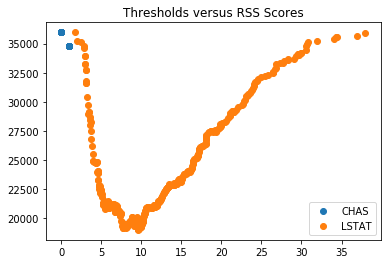

In [12]:
#Plot thresholds versus RSS scores

plt.scatter(CHAS, RSS_CHAS, label ='CHAS')
plt.scatter(LSTAT, RSS_LSTAT, label='LSTAT')
plt.title('Thresholds versus RSS Scores')
plt.legend(loc=4)
plt.show()

These two features have different characteristics, CHAS is dummy variable so we have only two choices for it. However, LSTAT is quantitative variable and it reaches the minimum RSS score when we split the data on 9.55

**(45 pts)** Now implement the training procedure of a regression tree using $RSS$ as split criteria. Build a rule tree recursively by traversing all features and considering each split threshold to find the optimum split, at every node.

You are free to implement training procedure as a standalone function or part of a class, but in any case use maximum depth as the stopping condition.

In [13]:
#To split the numpy array, we will need the index of the choosen feature name

def get_feature_index(feature_name):
    """Parameter is the feature name for the purpose of splitting and should be given as string"""
    
    for i in range(len(columns)):
        if(columns[i] == feature_name):
            return i

In [14]:
#Split the data on the given feature and threshold.

def split_data(all_data, feature_name, threshold):
    """"First parameter is all the training data and should be given as numpy array"""
    """Second parameter is the feature name for splitting and should be given as string"""
    """Third parameter is the threshold one wants to split from it"""
    
    feature_index = get_feature_index(feature_name)
    left_node = all_data[all_data[:, feature_index] < threshold]
    right_node = all_data[all_data[:, feature_index] >= threshold]
    return left_node, right_node

In [15]:
#To build the regression tree, and keep the nodes.

class Node:
    def __init__(self):
        self.feature = None
        self.left_node = None
        self.right_node = None
        self.threshold = None

In [16]:
#Build the regression tree

def build_regression_tree(data, feature_list, depth):
    """"First parameter is all the training data and should be given as numpy array"""
    """Second parameter is all the feature names and should be given as numpy array"""
    """Third parameter is the depth of the tree and should be given as integer"""
    
    all_RSS= []
    all_thresholds=[] 
    
    #To decide the feature and threshold for splitting by using RSS scores
    
    for i in range(len(feature_list)):      
        RSS, threshold = get_RSS_thresholds(data, feature_list[i])
        all_RSS.append(RSS)
        all_thresholds.append(threshold)
    
    #The best RSS is the minimum RSS, so choose the minimum of the all_RSS list which we fill in the above
    #Then keep the corresponding feature name and threshold
    
    best_RSS = min(all_RSS)
    threshold = all_thresholds[all_RSS.index(best_RSS)]
    feature_name = feature_list.tolist()[all_RSS.index(best_RSS)]
    
    left_node, right_node = split_data(data, feature_name, threshold)
    
    #If we reach the leaf the following condition is satisfied and return the method
    
    if(len(left_node)==0 or len(right_node)==0):
        return data
    
    #To keep in safe all the splitted thresholds and features use the Node class
    
    node = Node()

    node.left_node = left_node
    node.right_node = right_node
    node.threshold = threshold
    node.feature = feature_name
    
    #Left node features and right node features might be similar, not to lose them, use deep copy after the first split.
    
    feature_list = np.delete(feature_list, np.where(feature_list==feature_name))
        
    feature_left = copy.deepcopy(feature_list)
    feature_right = copy.deepcopy(feature_list)

    depth = depth -1
    
    #While depth is equal to zero, recursively work in the build_regression_tree
    
    if(depth > 0):
        
        node.left_node = build_regression_tree(node.left_node, feature_left, depth)
        node.right_node = build_regression_tree(node.right_node, feature_right, depth)
        
    return node

**(15 pts)** Having implemented the regression tree, now write a procedure to predict test features. Given a sample, this procedure should follow the rules learned during the training to arrive at a leaf and predict the output as the mean output of the arrived leaf samples. 

If you have implemented a regression tree class, you can insert this procedure as a class function 

In [17]:
#After we build the tree, we have all the columns, and data in the leaves, 
#our prediction metric is mean, so when new data comes by searching on the nodes try to reach one of the leaves
#Finally, take the mean of the price values to predict the price of the new house.

def predict(node, new_data, columns):
    """First parameter should be given as the Node type which we create above"""
    """Second parameter is the new data and should be given as numpy array with one row"""
    """Third parameter is all the feature names and should be given as numpy array"""
    
    while (not isinstance(node, np.ndarray)):
        for i in range(len(columns)):
            if(columns[i]==node.feature):
                if(new_data[i] < node.threshold):
                    node = node.left_node
                    if(type(node)==np.ndarray):
                        break
                else:
                    node = node.right_node
                    if(type(node)==np.ndarray):
                        break
                    
    prediction = np.mean(node[:,-1])
    
    return prediction

**(5 pts)** Train your model using a max depth of 3 and visualize the resulting tree. You can use an external tool such as draw.io or LaTeX for drawing. Annotate the nodes with split columns and thresholds. You can view the tree in this [link](https://scikit-learn.org/stable/modules/tree.html#tree) as an example. 

In [18]:
#Build the tree and print the node features and node thresholds to visualize the tree. 
#The external source draw.io is used for this purpose

node = build_regression_tree(all_data, boston.feature_names, 3)

In [19]:
#Print node features and thresholds

print(node.feature, node.threshold)
print(node.left_node.feature, node.left_node.threshold)
print(node.left_node.left_node.feature, node.left_node.left_node.threshold)
print(node.left_node.right_node.feature, node.left_node.right_node.threshold)
print(node.right_node.feature, node.right_node.threshold)
print(node.right_node.left_node.feature , node.right_node.left_node.threshold)
print(node.right_node.right_node.feature , node.right_node.right_node.threshold)

RM 6.943
LSTAT 14.43
DIS 1.413
NOX 0.609
LSTAT 4.73
DIS 3.2157
INDUS 11.93


In [20]:
#Print also the predictions 

print(np.mean(node.left_node.left_node.left_node[:,-1]))
print(np.mean(node.left_node.left_node.right_node[:,-1]))
print(np.mean(node.left_node.right_node.left_node[:,-1]))
print(np.mean(node.left_node.right_node.right_node[:,-1]))
print(np.mean(node.right_node.right_node.right_node[:,-1]))
print(np.mean(node.right_node.right_node.left_node[:,-1]))
print(np.mean(node.right_node.left_node.left_node[:,-1]))
print(np.mean(node.right_node.left_node.right_node[:,-1]))

45.58
22.927894736842106
18.41509433962264
12.968539325842697
23.119999999999997
35.690000000000005
48.1
40.934999999999995


## **(10 pts)** Task 3: Evaluation

**(5 pts)** Now is time to pick the best maximum depth and observe your tree's performance! Implement a 5-fold cross validation procedure to experiment with maximum depths from 3 to 10. Report mean and standard deviation for each depth and pick the best one. For comparison you can use $R^2$, which is a metric frequently used to evaluate regression models. You can use `r2_score` function of `scikit-learn` and read more [here](https://scikit-learn.org/stable/modules/model_evaluation.html#r2-score).

In [21]:
#Preprocess for the cross validation, split data into 5. 

def parser(all_data ,S):
    
    """"First parameter is all the training data and should be given as numpy array"""
    """Second parameter is the value which shows the how many divisions we will have"""
    
    remainder = (all_data.shape[0])%S
    if(remainder==0):
        data_converted = all_data
    else:
        data_converted = all_data[:-remainder, :]
        
    z = np.arange(data_converted.shape[0])
    np.random.seed(5)
    np.random.shuffle(z)
    data_converted = all_data[z]

    Splitted_data  = np.split(data_converted,S,axis=0)
    
    X_train_sets = []
    Y_test_sets = []

    X_train_set_1 = np.concatenate((Splitted_data[1],Splitted_data[2],Splitted_data[3],Splitted_data[4]),axis= 0)
    X_train_set_2 = np.concatenate((Splitted_data[0],Splitted_data[2],Splitted_data[3],Splitted_data[4]),axis= 0)
    X_train_set_3 = np.concatenate((Splitted_data[0],Splitted_data[1],Splitted_data[3],Splitted_data[4]),axis= 0)
    X_train_set_4 = np.concatenate((Splitted_data[0],Splitted_data[1],Splitted_data[2],Splitted_data[4]),axis= 0)
    X_train_set_5 = np.concatenate((Splitted_data[0],Splitted_data[1],Splitted_data[2],Splitted_data[3]),axis= 0)

    X_train_sets.append(X_train_set_1)
    X_train_sets.append(X_train_set_2)
    X_train_sets.append(X_train_set_3)
    X_train_sets.append(X_train_set_4)
    X_train_sets.append(X_train_set_5)
    
    Y_test_sets.append(Splitted_data[0])
    Y_test_sets.append(Splitted_data[1])
    Y_test_sets.append(Splitted_data[2])
    Y_test_sets.append(Splitted_data[3])
    Y_test_sets.append(Splitted_data[4])
    
    return X_train_sets,Y_test_sets

In [22]:
#Cross validation method is to find the R2 values for each split and find the optimum depth

def cross_validation(S, X_train_sets, Y_test_sets, feature_list, depth_list):
    """First parameter is the value which shows the how many divisions we will have"""
    """Second parameter is the subset of a train set"""
    """Third parameter is the subset of a train set which is not in the second parameter values"""
    """Forth parameter is all the feature names and should be given as numpy array"""
    """Fifth parameter is the list of possible depths"""
    
    results = np.empty([S,len(depth_list)])
    
    for i in range(0,S):
        for ii in range(0,len(depth_list)):
            prediction_list=[]
            node = build_regression_tree(X_train_sets[i], feature_list, depth_list[ii])
            
            for pred in range(len(Y_test_sets[i])):
                prediction = predict(node, Y_test_sets[i][pred], feature_list)
                prediction_list.append(prediction)
                
            #Calculate R2 values and put them in a result matrix
            
            R2 = r2_score(Y_test_sets[i][:,-1], prediction_list)     
            results[i][ii] = R2
            
    return results

In [23]:
#Call the cross validation method for the requested depths

depth_list = [depth for depth in range(3,11)]
S=5
train_sets, test_sets = parser(all_data,S)
results = cross_validation(S, train_sets, test_sets, boston.feature_names, depth_list)

In [24]:
#To examine the cross validation results, don't forget to install the PrettyTable class

R2_means = results.mean(0)
R2_stds = results.std(0)
table = PrettyTable()
table.field_names = ["Cross Validation","Depth = 3", "Depth = 4", "Depth = 5", "Depth = 6","Depth = 7","Depth = 8","Depth = 9","Depth = 10"]
table.add_row(["Cross Validation R2 Mean", format(R2_means[0], '.5f'),format(R2_means[1], '.5f'),format(R2_means[2], '.5f'),format(R2_means[3], '.5f'),format(R2_means[4], '.5f'),format(R2_means[5], '.5f'),format(R2_means[6], '.5f'),format(R2_means[7], '.5f')])
table.add_row(["Cross Validation R2 Std", format(R2_stds[0], '.5f'),format(R2_stds[1], '.5f'), format(R2_stds[2], '.5f'),format(R2_stds[3], '.5f'),format(R2_stds[4], '.5f'),format(R2_stds[5], '.5f'),format(R2_stds[6], '.5f'),format(R2_stds[7], '.5f')])
print(table)

+--------------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+
|     Cross Validation     | Depth = 3 | Depth = 4 | Depth = 5 | Depth = 6 | Depth = 7 | Depth = 8 | Depth = 9 | Depth = 10 |
+--------------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+
| Cross Validation R2 Mean |  0.68030  |  0.66028  |  0.67800  |  0.66992  |  0.66460  |  0.64875  |  0.63687  |  0.62776   |
| Cross Validation R2 Std  |  0.12522  |  0.15431  |  0.12937  |  0.12312  |  0.12715  |  0.14304  |  0.13357  |  0.13716   |
+--------------------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+


**(5 pts)** To conclude, train your tree one last time on the whole training data with the depth you picked in the previous section. Generate predictions on both training and test sets and report $R^2$ scores.

In [25]:
#By the result of cross validation the optimum depth is 3 by looking high R2 Mean and R2 Standard Deviation

In [26]:
result_tree = build_regression_tree(all_data, boston.feature_names, 3)

In [27]:
#For the training accuracy use the training data

training_prediction=[]
for i in range(len(all_data)):
    prediction = predict(result_tree, all_data[i], columns)
    training_prediction.append(prediction)

In [28]:
training_R2 = r2_score(train_label, training_prediction)
print(training_R2)

0.8037989073300135


In [29]:
#For the test accuracy use the test data
all_test_data = np.concatenate((test_data, test_label[:,None]), axis=1)

test_prediction=[]
for i in range(len(all_test_data)):
    prediction = predict(result_tree,all_test_data[i], columns)
    test_prediction.append(prediction)

In [30]:
test_R2 = r2_score(test_label, test_prediction)
print(test_R2)

0.7208113590667145
